# Emotion Recognition On Audio - CNN Model

## Importing needed libraries

In [1]:
%%capture
!pip install tensorflow-addons
!pip install sentencepiece
!pip install tensorflow_hub
!pip install transformers
!pip install pytest

In [2]:
# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np
import sentencepiece
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Transformer models Libraries and utilities, metrics
from sklearn.metrics import classification_report, f1_score
from keras.utils.data_utils import get_file
from keras.utils.data_utils import get_file
from transformers import AlbertTokenizer, TFAlbertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

EMO = ['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other']

# Download of the chosen model and its tokenizer
print('Using TensorFlow version', tf.__version__)
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = TFAlbertModel.from_pretrained("albert-base-v2")


random_seed = 42

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Using TensorFlow version 2.12.0


Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


## Preprocessing

### Dataset download

In [3]:
from google.colab import files

def download_dataset_from_kaggle_to_colab():
    files.upload()
    !ls -lha kaggle.json
    !pip install -q kaggle # Install kaggle API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d riccardopaolini/nlp-project-work
    !unzip nlp-project-work.zip
    clear_output()

download_dataset_from_kaggle_to_colab()

### Dataset conversion into table

In [4]:
def build_IEMOCAP_dataframe():
    folder = os.path.join(os.getcwd(), 'IEMOCAP')

    conv_id = 0

    df = []
    for session in os.listdir(folder):
        session_path = os.path.join(folder, session)
        # 'dialogue' folder contains Emotions and Transcripts
        # 'sentences' folder contains Audios

        trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

        for trans_name in os.listdir(trans_folder):
            if trans_name[:2] != '._':
                emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
                with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                    conv_id += 1
                    turn_id = 0
                    for line in trans_file:
                        #print(line.split('_'))
                        audio_name, text = line.split(':')
                        if trans_name.split('.')[0] in audio_name:
                            turn_id += 1

                            wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                            reached = False
                            count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                            for emo_line in emo_file:
                                if audio_name.split(' ')[0] in emo_line:
                                    emotion, vad = emo_line.split('\t')[-2:]
                                    vad = vad[1:-2].split(',')
                                    reached = True
                                elif emo_line[0] == 'C' and reached:
                                    evaluator = emo_line.split(':')[0]
                                    emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                    emotions = [em.strip() for em in emotions]
                                    for em in emotions:
                                        if em != '':
                                            count_em[em] += 1
                                elif reached:
                                    emo_file.seek(0)
                                    break
                                        

                            row = {'conv_id': conv_id, 
                                    'turn_id': turn_id, 
                                    'sentence': text.strip(),
                                    'path': wav_path,
                                    'emotion': emotion,
                                    'valence': float(vad[0]),
                                    'activation': float(vad[1]),
                                    'dominance': float(vad[2])
                                    }
                            
                            df.append(dict(**row, **count_em))

    return pd.DataFrame(df)

df = build_IEMOCAP_dataframe()
df.head()

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,"Brian, I need help.",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,sad,2.5,2.0,3.0,0,0,3,0,0,0,0,0,0,0
1,1,2,"Babe, I don't know what to tell you. Don't gi...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,neu,2.0,2.5,3.0,0,0,1,2,1,0,0,0,0,0
2,1,3,I don't--I'm just--I'm thinking maybe I should...,/content/IEMOCAP/Session5/sentences/wav/Ses05F...,xxx,2.0,3.0,3.5,0,0,2,0,2,0,0,0,0,1
3,1,4,"Well, of course not, but what are you going to...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,neu,2.5,3.0,3.5,0,0,0,2,2,0,0,0,0,0
4,1,5,"I don't know. I mean, what am I supposed to d...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,fru,2.0,3.0,3.0,0,0,1,0,2,0,0,0,0,1


In [5]:
df['history'] = df['sentence']

In [6]:
def preprocess(df):
    maximum = np.max(np.max(df.loc[:, ['valence', 'activation', 'dominance']]))
    
    for col in ['valence', 'activation', 'dominance']:
        df[col] = df[col] / maximum

    label = []
    vad_label = []
    for idx, row in df.iterrows():
        df.loc[idx, 'history'] = ''.join([df.loc[idx-t, 'sentence'] + ' ' for t in reversed(range(1, 5)) if idx-t >= 0 and df.loc[idx-t, 'conv_id'] == df.loc[idx, 'conv_id']])

        emotions = [
            row['Anger'], row['Happiness'], row['Sadness'], row['Neutral'], row['Frustration'], 
            row['Excited'], row['Fear'], row['Surprise'], row['Disgust'], row['Other']
        ]

        vad = [
            row['valence'], row['activation'], row['dominance']
        ]

        if np.sum(emotions) > 0: 
            label.append(emotions / np.sum(emotions))
        else:
            label.append(emotions)

        vad_label.append(vad)

    df['label'] = label
    df['vad'] = vad_label

preprocess(df)
df.head()

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,...,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other,history,label,vad
0,1,1,"Brian, I need help.",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,sad,0.454545,0.363636,0.545455,0,0,...,0,0,0,0,0,0,0,,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.45454545454545453, 0.36363636363636365, 0.5..."
1,1,2,"Babe, I don't know what to tell you. Don't gi...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,neu,0.363636,0.454545,0.545455,0,0,...,2,1,0,0,0,0,0,"Brian, I need help.","[0.0, 0.0, 0.25, 0.5, 0.25, 0.0, 0.0, 0.0, 0.0...","[0.36363636363636365, 0.45454545454545453, 0.5..."
2,1,3,I don't--I'm just--I'm thinking maybe I should...,/content/IEMOCAP/Session5/sentences/wav/Ses05F...,xxx,0.363636,0.545455,0.636364,0,0,...,0,2,0,0,0,0,1,"Brian, I need help. Babe, I don't know what to...","[0.0, 0.0, 0.4, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, ...","[0.36363636363636365, 0.5454545454545454, 0.63..."
3,1,4,"Well, of course not, but what are you going to...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,neu,0.454545,0.545455,0.636364,0,0,...,2,2,0,0,0,0,0,"Brian, I need help. Babe, I don't know what to...","[0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, ...","[0.45454545454545453, 0.5454545454545454, 0.63..."
4,1,5,"I don't know. I mean, what am I supposed to d...",/content/IEMOCAP/Session5/sentences/wav/Ses05F...,fru,0.363636,0.545455,0.545455,0,0,...,0,2,0,0,0,0,1,"Brian, I need help. Babe, I don't know what to...","[0.0, 0.0, 0.25, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0,...","[0.36363636363636365, 0.5454545454545454, 0.54..."


In [7]:
print(df.loc[5, 'history'])

Babe, I don't know what to tell you.  Don't give up. I don't--I'm just--I'm thinking maybe I should move back home or something.  I don't I don't know what to do.  I can't - I cant keep living the way I'm living. Well, of course not, but what are you going to do if you move back home?  Are you going to be able to find a job there? I don't know.  I mean, what am I supposed to do? I've It's not for lack of effort.  I've been trying. 


### Dataset inspection

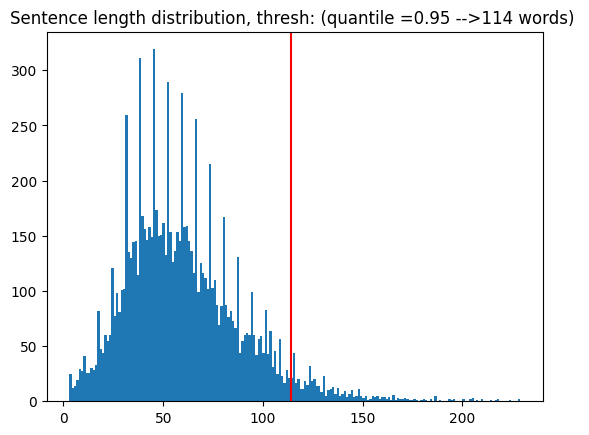

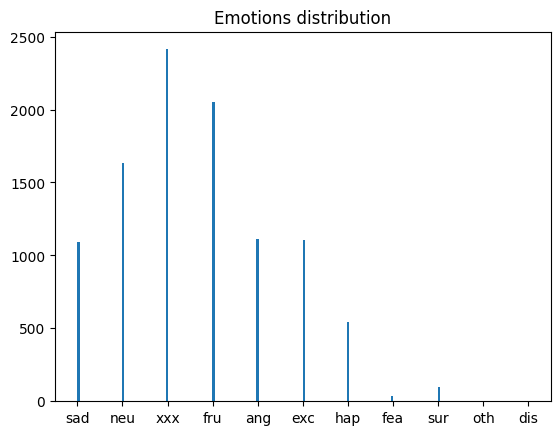

In [8]:
X = (df["history"] + ' [SEP] ' + df['sentence']).copy()
y = df.loc[:, ["emotion", "vad", "label"]].copy()


# drawing plot of the sentences length distribution

lengths = [len(t.split(' ')) for t in X]
quantile = 0.95
thresh = int(np.quantile(lengths, quantile))
plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile ={quantile} -->{thresh} words) ")
plt.axvline(x = thresh, color = 'r', label = 'axvline - full height')
plt.show()

# drawing plot of the emotions distribution
plt.hist(y['emotion'], bins = len(set(lengths)))
plt.title("Emotions distribution")
plt.show()

### Dataset split

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed, shuffle=True)# stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=random_seed, shuffle=True)

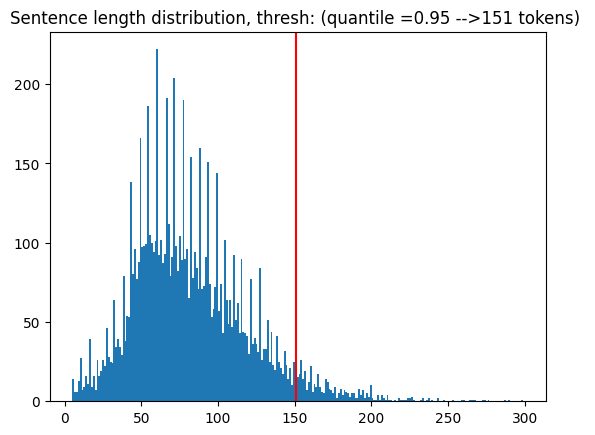

In [10]:
x_train_albert = tokenizer(
    text = X_train.tolist(),
    add_special_tokens=True,
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

lengths = [len(x) for x in x_train_albert['input_ids']]
quantile = 0.95
thresh = int(np.quantile(lengths, quantile))
plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile ={quantile} -->{thresh} tokens) ")
plt.axvline(x = thresh, color = 'r', label = 'axvline - full height')
plt.show()

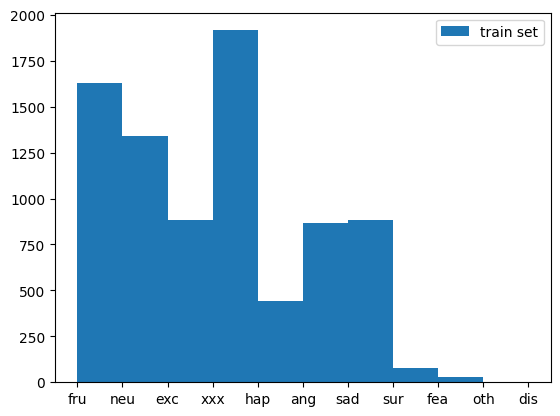

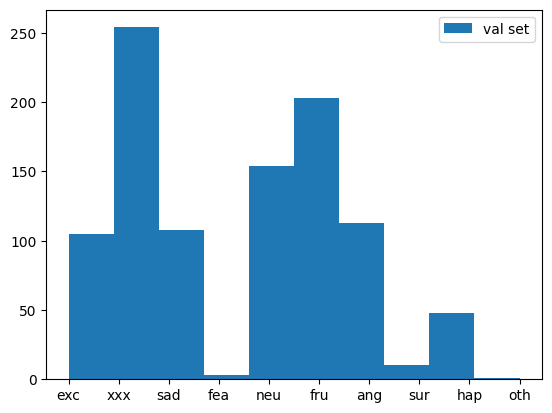

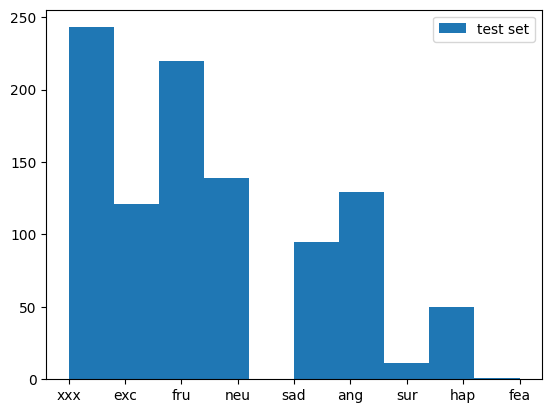

In [11]:
plt.hist(y_train['emotion'], label="train set")
plt.legend()
plt.show()
plt.hist(y_val['emotion'], label = "val set")
plt.legend()
plt.show()
plt.hist(y_test['emotion'], label = "test set")
plt.legend()
plt.show()

## ALBERT

### Tokenization

In [12]:
# setting length cut-limit for the sentences
maxlen = thresh

x_train_albert = tokenizer(
    text = X_train.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_albert = tokenizer(
    text = X_val.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test_albert = tokenizer(
    text = X_test.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = "max_length",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
     

### One-hot encoding of labels

In [13]:
encoded_dict= {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

y_train_albert = y_train.copy()
y_val_albert = y_val.copy()
y_test_albert = y_test.copy()

y_train_albert['emotion'] = y_train['emotion'].map(encoded_dict)

y_test_albert['emotion'] = y_test['emotion'].map(encoded_dict)

y_val_albert['emotion'] = y_val['emotion'].map(encoded_dict)

print("Before one-hot encoding: \n")
print(y_train)
print("Label count by class: \n")
print(np.unique(y_train['emotion'],return_counts=True))

print("After one-hot encoding: \n")
print(y_train_albert) 
print("Label count by class: \n")
print(np.unique(y_train_albert['emotion'],return_counts=True))


# testing if the label vector has still same dimension
assert len(y_train) == len(y_train_albert)
assert len(y_val) == len(y_val_albert)
assert len(y_test) == len(y_test_albert)

# checking if new vectors contain only integers
assert np.array_equal(y_train_albert['emotion'], y_train_albert['emotion'].astype(int))
assert np.array_equal(y_val_albert['emotion'], y_val_albert['emotion'].astype(int))
assert np.array_equal(y_test_albert['emotion'], y_test_albert['emotion'].astype(int))


Before one-hot encoding: 

     emotion                                                vad  \
3833     fru  [0.2727272727272727, 0.6363636363636364, 0.818...   
8973     neu  [0.5454545454545454, 0.5454545454545454, 0.545...   
994      exc  [0.7272727272727273, 0.8181818181818182, 0.818...   
5324     exc  [0.7272727272727273, 0.5454545454545454, 0.636...   
8403     xxx  [0.6363636363636364, 0.45454545454545453, 0.45...   
...      ...                                                ...   
9172     exc  [0.8181818181818182, 0.6363636363636364, 0.454...   
8558     sad  [0.5454545454545454, 0.5454545454545454, 0.363...   
7465     fru  [0.5454545454545454, 0.45454545454545453, 0.63...   
9226     hap  [0.5454545454545454, 0.5454545454545454, 0.545...   
7426     fru  [0.45454545454545453, 0.6363636363636364, 0.81...   

                                                  label  
3833                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
8973  [0.0, 0.0, 0.4, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 

### Model definition

In [17]:
# input
input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
# pretrained 
embeddings = albert([input_ids, input_mask])[0] #(0 is the last hidden layer, 1 means pooler output)
# last layers and output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(64, activation='relu', activity_regularizer=keras.regularizers.L2())(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(32, activation = 'relu', activity_regularizer=keras.regularizers.L2())(out)
out = tf.keras.layers.Dropout(0.2)(out)

y_dist = Dense(10, activation = 'softmax', name='dist_output')(out)

y_em = Dense(11, activation = 'softmax', name='em_output')(tf.concat([out, y_dist], -1))

y_vad = Dense(3, activation = 'linear', name='vad_output')(out)



model = tf.keras.Model(inputs=[input_ids, input_mask], outputs = [y_em, y_vad, y_dist])
model.layers[2].trainable = True

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 150)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  multiple            11683584    ['input_ids[0][0]',              
 )                                                                'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 768)         0           ['tf_albert_model[1][0]']  

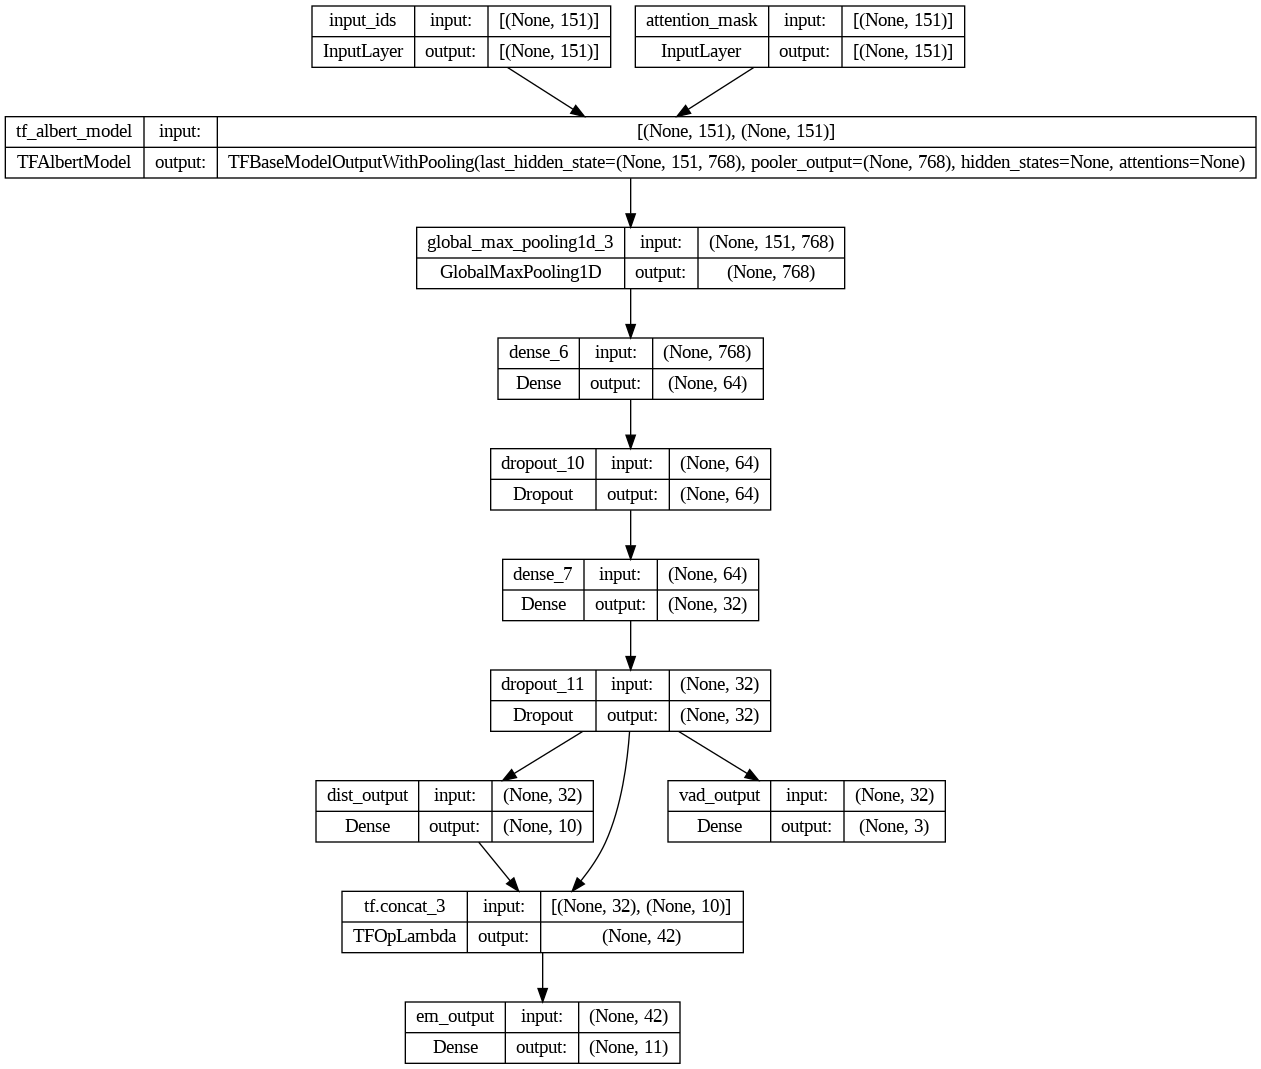

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Model training

In [19]:
# utility to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Training settings

In [20]:
optimizer=Adam(
    learning_rate = 1e-05, # this learning rate is for bert model, taken from hugging face site
)

# set loss and metrics 
#loss = 'categorical_crossentropy'#CategoricalCrossentropy(from_logits = True)
losses = {
	"em_output": keras.losses.CategoricalCrossentropy(),
	"vad_output": keras.losses.MeanSquaredError(),
  "dist_output": keras.losses.KLDivergence()
}
metric = {"em_output": CategoricalAccuracy(name='balanced_accuracy',dtype='float32'),
          "vad_output": keras.metrics.MeanSquaredError(),
          "dist_output": keras.metrics.KLDivergence()}

lossWeights = {"em_output": 20.0, "vad_output": 1.0, "dist_output": 10.0}
#lossWeights = {"em_output": 1.0, "vad_output": 0.005, "dist_output": 0.05}
#f1 = tfa.metrics.F1Score(num_classes=11,average='macro')

# compile the model
model.compile(
    optimizer = optimizer,
    loss = losses,
    metrics = metric,
    loss_weights=lossWeights,
)

#### Training

In [21]:
def convert(df):
  label = []
  for i, row in df.iterrows():
    label.extend([v for v in row.values])

  return np.array(label)

In [ ]:
print(to_categorical(y_train_albert["emotion"]))
print(convert(y_train_albert.loc[:, ["vad"]]))
print(convert(y_train_albert.loc[:, ["label"]]).shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[0.45454545 0.45454545 0.63636364]
 [0.45454545 0.63636364 0.72727273]
 [0.45454545 0.63636364 0.72727273]
 ...
 [0.27272727 0.72727273 0.81818182]
 [0.36363636 0.54545455 0.72727273]
 [0.27272727 0.81818182 0.81818182]]
(8079, 10)


In [22]:
albert_history = model.fit(
    x = {'input_ids': x_train_albert['input_ids'], 'attention_mask': x_train_albert['attention_mask']},
    
    y = {
          "em_output": to_categorical(y_train_albert["emotion"]),
          "vad_output": convert(y_train_albert.loc[:, ["vad"]]),
          "dist_output": convert(y_train_albert.loc[:, ["label"]])
         },

    validation_data = ({'input_ids': x_val_albert['input_ids'], 'attention_mask': x_val_albert['attention_mask']}, 
                       {
                          "em_output": to_categorical(y_val_albert["emotion"]),
                          "vad_output": convert(y_val_albert.loc[:, ["vad"]]),
                          "dist_output": convert(y_val_albert.loc[:, ["label"]])
                       }),
    epochs=20, 
    batch_size=16,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_em_output_balanced_accuracy', patience=4, verbose=1, mode='max', restore_best_weights=True),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor="val_em_output_balanced_accuracy", factor=0.1, patience=2)]
)

Epoch 1/20


505/505 [==============================] - 307s 564ms/step - loss: 59.7592 - em_output_loss: 2.2422 - vad_output_loss: 0.7981 - dist_output_loss: 1.3784 - em_output_balanced_accuracy: 0.1864 - vad_output_mean_squared_error: 0.7981 - dist_output_kullback_leibler_divergence: 1.3784 - val_loss: 56.3921 - val_em_output_loss: 2.1337 - val_vad_output_loss: 0.4865 - val_dist_output_loss: 1.2954 - val_em_output_balanced_accuracy: 0.2623 - val_vad_output_mean_squared_error: 0.4865 - val_dist_output_kullback_leibler_divergence: 1.2954 - lr: 1.0000e-05
Epoch 2/20
505/505 [==============================] - 283s 560ms/step - loss: 57.7927 - em_output_loss: 2.1747 - vad_output_loss: 0.5772 - dist_output_loss: 1.3444 - em_output_balanced_accuracy: 0.1999 - vad_output_mean_squared_error: 0.5772 - dist_output_kullback_leibler_divergence: 1.3444 - val_loss: 55.5062 - val_em_output_loss: 2.0931 - val_vad_output_loss: 0.3690 - val_dist_output_loss: 1.3027 - val_em_output_balanced_accuracy: 0.2823 - val_va

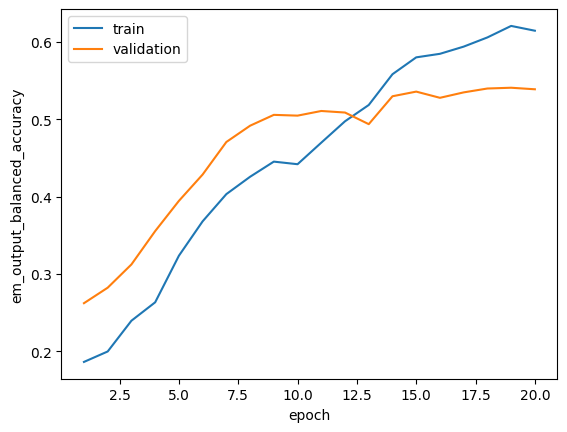

In [23]:
plot_history(albert_history,['em_output_balanced_accuracy','val_em_output_balanced_accuracy'])

### Testing

In [24]:
y_pred_albert = model.predict({'input_ids':x_test_albert['input_ids'],'attention_mask':x_test_albert['attention_mask']})

# convertion of the guessed label in integer labels
y_pred_albert = np.argmax(y_pred_albert[0], axis = 1)

f1_macro = f1_score(y_test_albert['emotion'],y_pred_albert, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

32/32 [==============================] - 15s 370ms/step
The final F1-score macro avg obtained on the test set is F1 = 0.3804957328099976


In [25]:
print(classification_report(y_test_albert['emotion'],y_pred_albert))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       129
           2       0.61      0.67      0.64       121
           3       0.00      0.00      0.00         1
           4       0.58      0.59      0.58       220
           5       0.67      0.04      0.08        50
           6       0.43      0.29      0.35       139
           8       0.67      0.75      0.71        95
           9       0.00      0.00      0.00        11
          10       0.44      0.59      0.50       243

    accuracy                           0.53      1009
   macro avg       0.44      0.39      0.38      1009
weighted avg       0.53      0.53      0.52      1009



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_albert['emotion'],y_pred_albert)

0.4360753221010902

## Bi-LSTM

In [ ]:
!pip install text_hammer
import text_hammer as th
import re
tf.random.set_seed(random_seed)

def text_lite_preprocessing(data, col_name):
  column = col_name
  df = data.copy().to_frame()
  df[column] = df[column].progress_apply(lambda x: str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're --> you are
  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
  df[column] = df[column].progress_apply(lambda x: re.sub(r'\d', "number", x))
  df[column] = df[column].progress_apply(lambda x: re.sub("_", "number", x))
  return (df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_clean_litemodel = text_lite_preprocessing(X_train, "sentence")
test_clean_litemodel = text_lite_preprocessing(X_test, "sentence")
val_clean_litemodel = text_lite_preprocessing(X_val, "sentence")

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
print(train_clean_litemodel)

                                               sentence
3833                         well you help me stay here
8973                                          yeah yeah
994   and so i am getting the animals putting the an...
5324  and i got to i got to work here all day long o...
8403                        with the most perfect poise
...                                                 ...
9172  it is just fish i mean nothing to get traumati...
8558                           you cannot read her mind
7465                     we were very much younger then
9226  i do not know it seemed like a pretty good spo...
7426  youre a considerate fellow there is nothing wr...

[8079 rows x 1 columns]


### Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# creating tokenizer and fitting it on the training test
tokenizer = Tokenizer(num_words = None, oov_token='', split=' ', lower=False)
tokenizer.fit_on_texts(X)
print(tokenizer.get_config())


# printing a tokenization example
print("## Before tokenization: ")
print(train_clean_litemodel.iloc[2])
print("## After tokenization: ")
print(tokenizer.texts_to_sequences(train_clean_litemodel.sentence)[2])

{'num_words': None, 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '', 'document_count': 10087, 'word_counts': '{"How\'s": 13, "it": 1799, "going": 700, "babe": 6, "Yeah": 490, "All": 145, "right": 519, "Good": 25, "Hey": 45, "listen": 35, "eh": 2, "I\'ve": 207, "been": 255, "wanting": 1, "to": 3245, "talk": 77, "you": 4209, "I": 5578, "have": 954, "something": 245, "tell": 157, "Amy": 3, "doing": 121, "She\'s": 57, "fine": 62, "She": 71, "just": 1044, "took": 47, "her": 242, "first": 96, "steps": 3, "today": 28, "actually": 55, "videotaped": 1, "for": 785, "so": 613, "can": 548, "watch": 8, "yeah": 181, "oh": 72, "really": 287, "want": 660, "say": 145, "that": 1796, "Well": 616, "know": 1716, "at": 432, "the": 2377, "center": 8, "department": 7, "they": 419, "called": 14, "me": 1004, "in": 967, "and": 1968, "talked": 8, "Oh": 500, "What": 554, "did": 248, "umm": 6, "was": 696, "promoted": 3, "wow": 9, "That\'s": 253, 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, dataset, maxlen):
  sequences = tokenizer.texts_to_sequences(dataset)
  print(sequences)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen= maxlen)
  return padded



In [ ]:
padded_train_seq = get_sequences(tokenizer, train_clean_litemodel.sentence, maxlen=thresh)
padded_val_seq = get_sequences(tokenizer, val_clean_litemodel.sentence, maxlen=thresh)
padded_test_seq = get_sequences(tokenizer, test_clean_litemodel.sentence, maxlen=thresh)

[[170, 3, 140, 16, 231, 50], [114, 114], [7, 35, 1555, 121, 260, 5, 970, 705, 5, 970, 43, 19, 5, 936, 1555, 121, 705, 36, 31, 495, 260, 5, 317, 43, 11, 5, 1097], [7, 1555, 56, 4, 1555, 56, 4, 151, 50, 37, 213, 103, 149, 1555, 20, 56, 4, 485, 44, 3, 113, 37, 213], [44, 5, 545, 880, 1251], [1838, 27, 3, 20, 50, 14, 1190, 7, 66, 14, 816, 36, 8], [154, 1555, 21, 23, 10, 147], [1, 173, 100, 6, 1215, 720], [1555, 40, 63, 9], [60, 28, 318, 61, 5, 263, 94], [5, 158, 5, 158, 234, 23, 1113, 16], [1555, 702, 140, 8, 1555, 10, 88, 269, 1555, 26, 1120, 343, 684, 4, 88, 31, 181, 199, 240, 138, 107, 1555, 57, 11, 6, 915, 1555, 57, 11, 1], [8, 30, 6, 159, 11, 815, 189, 24, 189, 3, 145, 16], [58, 58, 58], [35, 1, 13, 5, 319, 514, 1374], [22, 1, 22, 22, 14, 23, 131, 486, 211, 340, 36, 5, 265, 974, 7, 209], [264, 24, 93, 146], [27, 55, 3, 21, 23, 122, 78], [7, 1555, 100, 22, 360, 74, 1555, 30, 699, 83, 46, 178, 13, 161, 30, 258, 941, 3, 10, 48, 1555, 457, 13, 22, 68, 190, 94, 30, 258, 377, 3, 10, 8, 14, 

### One-hot encoding of labels

In [ ]:
class_to_index = {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

names_to_ids = lambda labels_to_conv: np.array([class_to_index.get(x) for x in labels_to_conv])

y_train_litemodel = names_to_ids(y_train)
y_val_litemodel = names_to_ids(y_val)
y_test_litemodel =  names_to_ids(y_test)

print(len(y_train_litemodel))

8079


### Model definition

In [ ]:

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(tokenizer.document_count, 64, input_length=thresh),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(11,activation='Softmax')
        
])


In [ ]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 33, 64)            645568    
                                                                 
 bidirectional_40 (Bidirecti  (None, 33, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 11)                1419      
                                                                 
Total params: 811,851
Trainable params: 811,851
Non-trainable params: 0
_________________________________________________________________


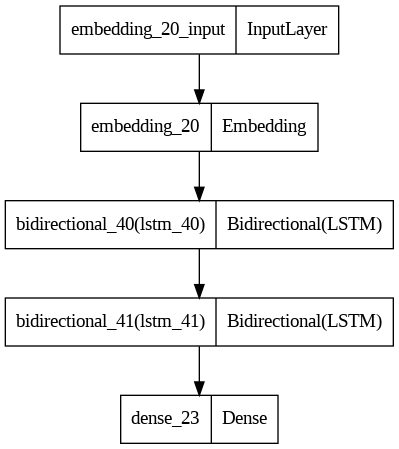

In [ ]:
tf.keras.utils.plot_model(model)

### Model training

In [ ]:
# utility to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Training settings

In [ ]:
f1 = tfa.metrics.F1Score(num_classes=11,average='macro')
accuracy = 'accuracy'

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=5e-3),
    metrics = [accuracy,f1]
)

#### Training

In [ ]:
bilstm_history = model.fit(
    padded_train_seq, to_categorical(y_train_litemodel),
    validation_data=(padded_val_seq, to_categorical(y_val_litemodel)),
    epochs =15,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3, verbose=1, mode='max', restore_best_weights=True)],
    batch_size=70
)

Epoch 1/15
116/116 [==============================] - 63s 404ms/step - loss: 1.8567 - accuracy: 0.2753 - f1_score: 0.1196 - val_loss: 1.6877 - val_accuracy: 0.3413 - val_f1_score: 0.1945
Epoch 2/15
116/116 [==============================] - 36s 313ms/step - loss: 1.5785 - accuracy: 0.4085 - f1_score: 0.2313 - val_loss: 1.6048 - val_accuracy: 0.3874 - val_f1_score: 0.2128
Epoch 3/15
116/116 [==============================] - 22s 192ms/step - loss: 1.4138 - accuracy: 0.4752 - f1_score: 0.2823 - val_loss: 1.5913 - val_accuracy: 0.4064 - val_f1_score: 0.2333
Epoch 4/15
116/116 [==============================] - 21s 180ms/step - loss: 1.3044 - accuracy: 0.5209 - f1_score: 0.3206 - val_loss: 1.5888 - val_accuracy: 0.4164 - val_f1_score: 0.2496
Epoch 5/15
116/116 [==============================] - 22s 193ms/step - loss: 1.2013 - accuracy: 0.5563 - f1_score: 0.3489 - val_loss: 1.6442 - val_accuracy: 0.4064 - val_f1_score: 0.2485
Epoch 6/15
116/116 [==============================] - 21s 178ms/s

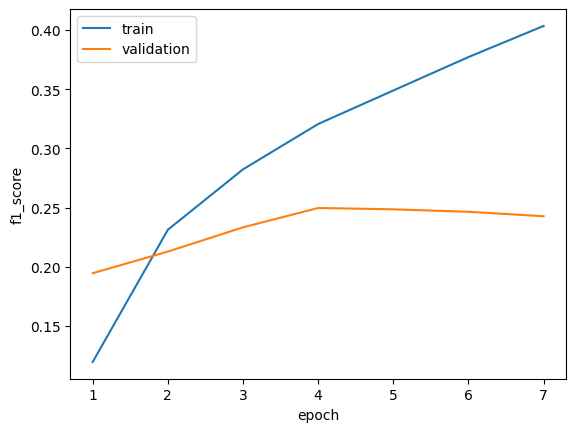

In [ ]:
plot_history(bilstm_history,['f1_score','val_f1_score'])

### Testing

In [ ]:
y_pred_litemodel = model.predict(padded_test_seq)
# convertion of the guessed label in integer labels
y_pred_litemodel = np.argmax(y_pred_litemodel, axis = 1)

32/32 [==============================] - 3s 38ms/step


In [ ]:
f1_macro = f1_score(y_test_litemodel,y_pred_litemodel, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

The final F1-score macro avg obtained on the test set is F1 = 0.3129173980596635


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_litemodel,y_pred_litemodel))
     

              precision    recall  f1-score   support

           0       0.56      0.37      0.45       105
           2       0.56      0.34      0.42       111
           3       0.00      0.00      0.00         4
           4       0.50      0.47      0.48       219
           5       0.50      0.17      0.25        65
           6       0.34      0.40      0.37       163
           8       0.40      0.51      0.45       106
           9       0.00      0.00      0.00        15
          10       0.33      0.48      0.39       221

    accuracy                           0.41      1009
   macro avg       0.35      0.30      0.31      1009
weighted avg       0.43      0.41      0.41      1009



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_litemodel,y_pred_litemodel)

0.41129831516352827